In [40]:
# Data handling and analysis
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

In [24]:
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")

# print("Path to dataset files:", path)
df = pd.read_csv(path + "/Clean_Dataset.csv")

df.head(5)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [25]:
# dropping unnecessary columns
df.drop(columns=['Unnamed: 0', 'flight'], inplace=True)

# Inspecting the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   source_city       300153 non-null  object 
 2   departure_time    300153 non-null  object 
 3   stops             300153 non-null  object 
 4   arrival_time      300153 non-null  object 
 5   destination_city  300153 non-null  object 
 6   class             300153 non-null  object 
 7   duration          300153 non-null  float64
 8   days_left         300153 non-null  int64  
 9   price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 22.9+ MB


In [26]:
print(f"amount of duplicated rows: {df.duplicated().sum()}\n")

# drop duplicates
df.drop_duplicates(inplace=True)
print(f"amount of duplicated rows after dropping: {df.duplicated().sum()}\n")

print(f"NaN values: \n{df.isna().sum()}")

amount of duplicated rows: 2213

amount of duplicated rows after dropping: 0

NaN values: 
airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


In [27]:
# get all the unique times and classes so we can apply label encoding
print(f"Unique values in 'departure_time' column: {df['departure_time'].unique()}")
print(f"Unique values in 'class' column: {df['class'].unique()}")
print(f"Unique values in 'stops' column: {df['stops'].unique()}")

Unique values in 'departure_time' column: ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
Unique values in 'class' column: ['Economy' 'Business']
Unique values in 'stops' column: ['zero' 'one' 'two_or_more']


In [28]:
# preparing enumeration so we can use it to map the values to integers in label encoding
timing_enum = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']
class_enum = ['Economy', 'Business']
stops_enum = ['zero', 'one', 'two_or_more']

# Convert 'departure_time' and 'arrival_time' to ordinal categories
departure_dtype = pd.CategoricalDtype(categories=timing_enum, ordered=True)
arrival_dtype = pd.CategoricalDtype(categories=timing_enum, ordered=True)
class_dtype = pd.CategoricalDtype(categories=class_enum, ordered=True)
stops_dtype = pd.CategoricalDtype(categories=stops_enum, ordered=True)

# Applying label encoding
df['departure_time'] = df['departure_time'].astype(departure_dtype).cat.codes
df['arrival_time'] = df['arrival_time'].astype(arrival_dtype).cat.codes
df['class'] = df['class'].astype(class_dtype).cat.codes
df['stops'] = df['stops'].astype(stops_dtype).cat.codes
df.head(5)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,3,0,4,Mumbai,0,2.17,1,5953
1,SpiceJet,Delhi,0,0,1,Mumbai,0,2.33,1,5953
2,AirAsia,Delhi,0,0,0,Mumbai,0,2.17,1,5956
3,Vistara,Delhi,1,0,2,Mumbai,0,2.25,1,5955
4,Vistara,Delhi,1,0,1,Mumbai,0,2.33,1,5955


In [29]:
# Apply one-hot encoding to the categorical columns
df = pd.get_dummies(df, columns=['airline', 'source_city', 'destination_city'], drop_first=True)
df.head(5)

,departure_time,stops,arrival_time,class,duration,days_left,price,airline_Air_India,airline_GO_FIRST,airline_Indigo,...,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,3,0,4,0,2.17,1,5953,False,False,False,...,False,True,False,False,False,False,False,False,False,True
1,0,0,1,0,2.33,1,5953,False,False,False,...,False,True,False,False,False,False,False,False,False,True
2,0,0,0,0,2.17,1,5956,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,1,0,2,0,2.25,1,5955,False,False,False,...,False,True,False,False,False,False,False,False,False,True
4,1,0,1,0,2.33,1,5955,False,False,False,...,False,True,False,False,False,False,False,False,False,True


In [30]:
temp = df.copy(deep=False) # so that it doesnt affect original df in next line

# randomizing feature selection
X = temp.drop(columns=['price'], axis=1).sample(frac=0.5, axis=1)
X

# splitting the last 15 records for manual testing/future prediction
X_last_15 = X[-15:]
X = X[:-15]
y_last_15 = temp['price'][-15:]
y = temp['price'][:-15]


In [31]:
# splitting the remaining data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

naive bayes below

In [33]:
# Create bins for target (since Naive Bayes needs discrete classes)
binner = KBinsDiscretizer(n_bins=75, encode='ordinal', strategy='quantile')
y_train_binned = binner.fit_transform(y_train.values.reshape(-1, 1))
y_test_binned = binner.transform(y_test.values.reshape(-1, 1))

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train_binned.ravel())

# Predict and transform back to original scale
train_pred_binned = nb_model.predict(X_train)
test_pred_binned = nb_model.predict(X_test)

train_predictions = binner.inverse_transform(train_pred_binned.reshape(-1, 1))
test_predictions = binner.inverse_transform(test_pred_binned.reshape(-1, 1))

# Calculate scores
nb_train_r2 = r2_score(y_train, train_predictions)
nb_test_r2 = r2_score(y_test, test_predictions)
nb_train_mse = mean_squared_error(y_train, train_predictions)
nb_test_mse = mean_squared_error(y_test, test_predictions)

print(f'Training R2 Score: {nb_train_r2:.4f}')
print(f'Test R2 Score: {nb_test_r2:.4f}')
print(f'Training MSE: {nb_train_mse:.4f}')
print(f'Test MSE: {nb_test_mse:.4f}')

# test the last 15 records and calculate the scores
last_15_predictions = nb_model.predict(X_last_15)
last_15_predictions = binner.inverse_transform(last_15_predictions.reshape(-1, 1))

last_15_r2 = r2_score(y_last_15, last_15_predictions)
last_15_mse = mean_squared_error(y_last_15, last_15_predictions)
print(f'Last 15 R2 Score: {last_15_r2:.4f}')
print(f'Last 15 MSE: {last_15_mse:.4f}')

Training R2 Score: -1.1806
Test R2 Score: -1.1721
Training MSE: 1126845110.8915
Test MSE: 1122672962.5173
Last 15 R2 Score: -0.5862
Last 15 MSE: 253342801.5333


In [32]:
rf_regress = RandomForestRegressor()

rf_regress.fit(X_train, y_train)

# Make predictions
train_predictions = rf_regress.predict(X_train)
test_predictions = rf_regress.predict(X_test)

# Calculate metrics
rf_train_r2 = r2_score(y_train, train_predictions)
rf_test_r2 = r2_score(y_test, test_predictions)
rf_mse_train = mean_squared_error(y_train, train_predictions)
rf_mse_test = mean_squared_error(y_test, test_predictions)

print(f'Training R2 Score: {rf_train_r2:.4f}')
print(f'Test R2 Score: {rf_test_r2:.4f}')
print(f'Training MSE: {rf_mse_train:.4f}')
print(f'Test MSE: {rf_mse_test:.4f}')

# testing the last 15 records
last_15_predictions = rf_regress.predict(X_last_15)
last_15_r2 = r2_score(y_last_15, last_15_predictions)
last_15_mse = mean_squared_error(y_last_15, last_15_predictions)

print(f'Last 15 records\' R2 Score: {last_15_r2:.4f}')
print(f'Last 15 records\' MSE: {last_15_mse:.4f}')

Training R2 Score: 0.4798
Test R2 Score: -0.2882
Training MSE: 268817351.5814
Test MSE: 665835681.1500
Last 15 records' R2 Score: -9.5835
Last 15 records' MSE: 1690422265.4187


In [ ]:
xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train, y_train)

train_predictions = xgb_model.predict(X_train)
test_predictions = xgb_model.predict(X_test)

xgb_train_mse = mean_squared_error(y_train, train_predictions)
xgb_test_mse = mean_squared_error(y_test, test_predictions)
xgb_train_r2 = r2_score(y_train, train_predictions)
xgb_test_r2 = r2_score(y_test, test_predictions)

print(f'Training R2 Score: {xgb_train_r2:.4f}')
print(f'Test R2 Score: {xgb_test_r2:.4f}')
print(f'\nTrainingRMSE: {xgb_train_mse:.2f}')
print(f'Test MSE: {xgb_test_r2:.2f}')

# testing the last 15 records
last_15_predictions = xgb_model.predict(X_last_15)
last_15_r2 = r2_score(y_last_15, last_15_predictions)
last_15_mse = mean_squared_error(y_last_15, last_15_predictions)

print(f'Last 15 records\' R2 Score: {last_15_r2:.4f}')
print(f'Last 15 records\' MSE: {last_15_mse:.4f}')

<>:24: SyntaxWarning: invalid escape sequence '\i'
<>:24: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_27203/3850968125.py:24: SyntaxWarning: invalid escape sequence '\i'
  print(f'Last 15 records\i MSE: {last_15_mse:.4f}')


Training R2 Score: 0.2477
Test R2 Score: 0.2291

TrainingRMSE: 388782762.24
Test MSE: 0.23
Last 15 records' R2 Score: -6.3332
Last 15 records\i MSE: 1171276434.7786


In [35]:
# KFold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [49]:
# performing cross-validation for testing the model
rf_scores = cross_val_score(rf_regress, X, y, cv=kf, scoring='neg_mean_squared_error')
rf_mse_score = -(rf_scores.mean())  # Convert negative MSE to positive
print(f'Cross-validated MSE for random forest: {rf_mse_score:.4f}')

Cross-validated MSE for random forest: 713149219.9450


In [50]:
xgb_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='neg_mean_squared_error')
xgb_mse_score = -(xgb_scores.mean())
print(f'Cross-validated R2 for XGboost: {xgb_mse_score:.4f}')

Cross-validated R2 for XGboost: 397399659.5680


In [51]:
# Perform cross-validation
nb_score = cross_val_score(nb_model, X, y, cv=kf, scoring='neg_mean_squared_error')
nb_score = -(nb_score.mean())
print(f'Cross-validated R2 for naive bayes: {nb_score:.4f}')

Cross-validated R2 for naive bayes: 1048349879.4854


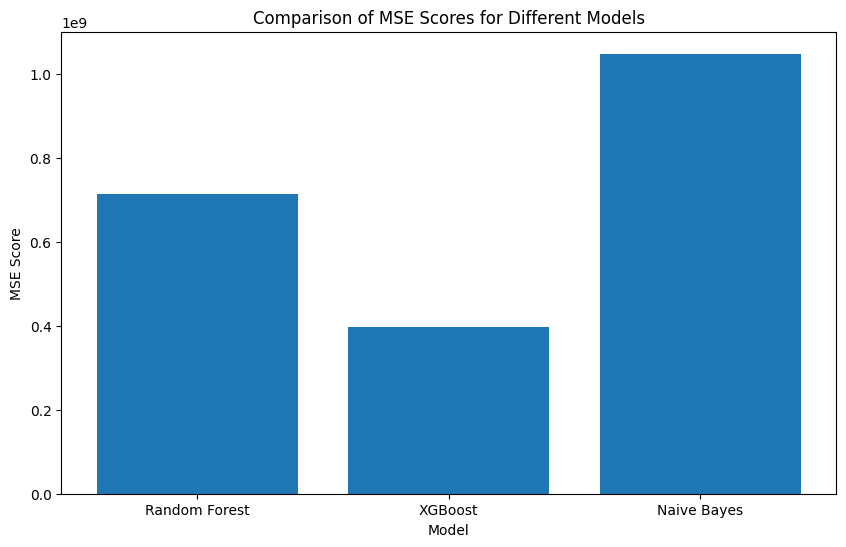

In [52]:
# Visualizing the results for comparison
plt.figure(figsize=(10, 6))
plt.bar(['Random Forest', 'XGBoost', 'Naive Bayes'], [rf_mse_score, xgb_mse_score, nb_score])
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.title('Comparison of MSE Scores for Different Models')
plt.show()
